# Experimentación - AGREGANDO DATA EXTERNA vol2

## Modelo - Tasa de suicidios (Ambos sexos)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence as influence

def rmse(fitted, target):
    rmse = np.sqrt(mean_squared_error(target, fitted))
    return rmse

def adjusted_r2(p, fitted, target):
    n=len(target)
    return 1 - (1-r2_score(target, fitted)) * (n-1) / (n-p-1)

def standarized_residual_plot(predicted, actual):
    residuals = actual - predicted
    standarized_residuals = residuals/np.std(residuals)
    plt.scatter(predicted, standarized_residuals)
    plt.xlabel("Predicciones")
    plt.ylabel("Residuos standarizados")
    plt.hlines(0, xmin=min(predicted), xmax=max(predicted))
    plt.title("Residuos standarizados")
    return standarized_residuals

def ols_influence(lm):
    plt.figure(figsize=(30,30))
    sm.graphics.influence_plot(lm, alpha  = 0.05, criterion="cooks")
    plt.show()

    
def run_analysis(predictors, dataset):
    target = dataset['Life expectancy']
    p=len(predictors)
    features= dataset[predictors].to_numpy()
    if len(predictors)>1:
        for i in range(0, len(predictors)):
            print(f"VIF for {predictors[i]} {variance_inflation_factor(features, i)}")

    features = sm.add_constant(features)
    regr = sm.OLS(target, features).fit()
    fitted = regr.predict(features)
    print(regr.summary())
    standarized_residuals = standarized_residual_plot(fitted, target)
    ols_influence(regr)
    #sm.qqplot(regr.resid)
    plt.figure()
    plt.hist(regr.resid)
    plt.show()
    return {
        'r2':r2_score(target, fitted),
        'rmse':rmse(fitted, target),
        'adjusted':adjusted_r2(p, fitted, target)
    }

# Me da los residuos estandarizados
def residuos(predictors, dataset):
    target = dataset['Life expectancy']
    p=len(predictors)
    features= dataset[predictors].to_numpy()
    if len(predictors)>1:
        for i in range(0, len(predictors)):
            print(f"VIF for {predictors[i]} {variance_inflation_factor(features, i)}")

    features = sm.add_constant(features)
    regr = sm.OLS(target, features).fit()
    fitted = regr.predict(features)
    standarized_residuals = standarized_residual_plot(fitted, target)
    return np.array(standarized_residuals)


# Me da la distancia de Cook de cada pais
def cooksDist(predictors, dataset):
    target = dataset['Life expectancy']
    p=len(predictors)
    features= dataset[predictors].to_numpy()
    if len(predictors)>1:
        for i in range(0, len(predictors)):
            print(f"VIF for {predictors[i]} {variance_inflation_factor(features, i)}")

    features = sm.add_constant(features)
    regr = sm.OLS(target, features).fit()
    inf = influence(regr)
    # cooks_distance is an attribute of incluence, here C, not sure about P (p-value maybe?)
    C, P = inf.cooks_distance
    return C, P

# Me da el Leverage de cada pais
def getLeverage(predictors, dataset):
    target = dataset['Life expectancy']
    p=len(predictors)
    features= dataset[predictors].to_numpy()
    if len(predictors)>1:
        for i in range(0, len(predictors)):
            print(f"VIF for {predictors[i]} {variance_inflation_factor(features, i)}")

    features = sm.add_constant(features)
    regr = sm.OLS(target, features).fit()
    inf = influence(regr)
    leverage = inf.hat_matrix_diag
    return leverage


df_exp = pd.read_csv("expectativa_de_vida.csv")
df_suic = pd.read_csv("suicide-rate.csv")

### Como el dataframe posee data de muchos años, elijo el 2015 para tratar la regresión.

In [2]:
df_suic = df_suic[df_suic['Period'] == 2015]

### Primero me interesa ver cómo afecta la tasa de suicidios de toda la población de un país con respecto a su expectativa de vida. Por lo tanto, elijo los casos de ambos sexos, no sólo el de uno u otro. Luego compararé cómo se diferencia el análisis si sólo tomo el dato de las mujeres o sólo el dato de los hombres.

In [3]:
df_suic_both = df_suic[df_suic['Dim1'] == 'Both sexes'] #Ambos sexos
df_suic_m = df_suic[df_suic['Dim1'] == 'Female'] #Mujeres
df_suic_h = df_suic[df_suic['Dim1'] == 'Male'] #Hombres

In [4]:
df_suic_both.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183 entries, 2199 to 2742
Data columns (total 34 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   IndicatorCode               183 non-null    object 
 1   Indicator                   183 non-null    object 
 2   ValueType                   183 non-null    object 
 3   ParentLocationCode          183 non-null    object 
 4   ParentLocation              183 non-null    object 
 5   Location type               183 non-null    object 
 6   SpatialDimValueCode         183 non-null    object 
 7   Location                    183 non-null    object 
 8   Period type                 183 non-null    object 
 9   Period                      183 non-null    int64  
 10  IsLatestYear                183 non-null    bool   
 11  Dim1 type                   183 non-null    object 
 12  Dim1                        183 non-null    object 
 13  Dim1ValueCode               183

### Junto el data frame de la cátedra con el dataframe de la tasa de suicidios.

In [5]:
paises = []
nombres1 = df_exp["Country"].tolist()
nombres2 = df_suic["Location"].tolist()

from difflib import SequenceMatcher

for i in range(len(nombres1)):
    n1 = nombres1[i]
    
    conSubstringsEnComun = []
    
    for j in range(len(nombres2)):
        n2 = nombres2[j]
        seq = SequenceMatcher(None, n1, n2)
        match = seq.find_longest_match(0,len(n1),0,len(n2))
        r = seq.ratio()
        
        if ((match[2] == len(n1)) or (match[2] == len(n2)) or (match[2] > 3 and r>0.6)):
            conSubstringsEnComun.append([r,n1,n2])
        
    conSubstringsEnComun.sort()
    conSubstringsEnComun.reverse()
    
    
    if (len(conSubstringsEnComun) > 0):
        paises.append([conSubstringsEnComun[0][1], conSubstringsEnComun[0][2]])
    else:
        paises.append(n1)

In [6]:
df = df_exp
suicidios_both = []
suicidios_m = []
suicidios_h = []

for i in range(len(paises)):
    suic_both = df_suic_both[df_suic_both["Location"]==paises[i][1]]["FactValueNumeric"].values
    suic_m = df_suic_m[df_suic_m["Location"]==paises[i][1]]["FactValueNumeric"].values
    suic_h = df_suic_h[df_suic_h["Location"]==paises[i][1]]["FactValueNumeric"].values

    suicidios_both.append(suic_both[0])
    suicidios_m.append(suic_m[0])
    suicidios_h.append(suic_h[0])

    
    
df["Suicidios Ambos"] = suicidios_both
df["Suicidios Mujeres"] = suicidios_m
df["Suicidios Hombres"] = suicidios_h

### Ya tengo agregada la tasa de suicidios para cada caso que quería (año 2015).

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183 entries, 0 to 182
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       183 non-null    int64  
 1   Country                          183 non-null    object 
 2   Life expectancy                  183 non-null    float64
 3   Adult Mortality                  183 non-null    float64
 4   infant deaths                    183 non-null    float64
 5   Alcohol                          182 non-null    float64
 6   percentage expenditure           183 non-null    float64
 7   Hepatitis B                      174 non-null    float64
 8   Measles                          183 non-null    float64
 9   BMI                              181 non-null    float64
 10  under-five deaths                183 non-null    float64
 11  Polio                            183 non-null    float64
 12  Total expenditure     

### La tabla nueva que exportamos trata sobre la cantidad de suicidios cada 100.000 habitantes por país. Me llevé una sorpresa ya que para mí era muy común escuchar sobre 'grandes tasas de suicidios en países muy desarrollados'. Para poner un ejemplo, Suecia o Japón. Pero viendo estos histogramas de abajo puedo constatar que mi percepción era equivocada. Los países subdesarrollados poseen un índice mayor, tanto para toda la poblacion como para hombres o mujeres por separado.

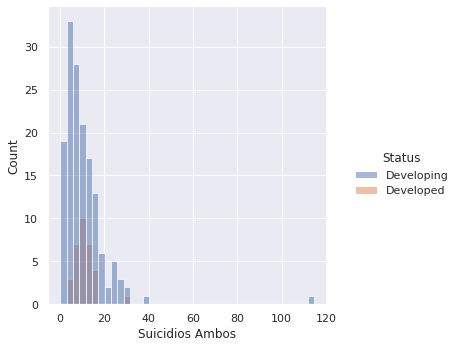

In [8]:
sns.set(rc={'figure.figsize':(15,10)})
sns.displot(df, x='Suicidios Ambos', bins=40, hue="Status")

### En cambio, hay otra percepción en la que sí acerté. Y es en que los hombres (en general) cometen más suicidios que las mujeres. Tal vez gire en torno a la responsabilidad que la sociedad les pone en la cabeza sobre "proveer a la familia, ser exitoso, trabajar largas horas, etc". A esto se le suma que a los hombres puede costarles más expresar sus sentimientos debido a décadas y décadas de reprimirlos. Se puede decir que los datos se condicen con estas observaciones. 

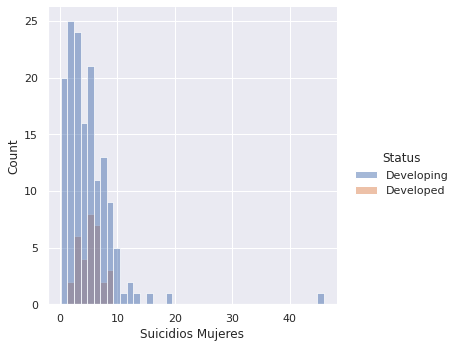

In [9]:
sns.displot(df, x='Suicidios Mujeres', bins=40, hue="Status")

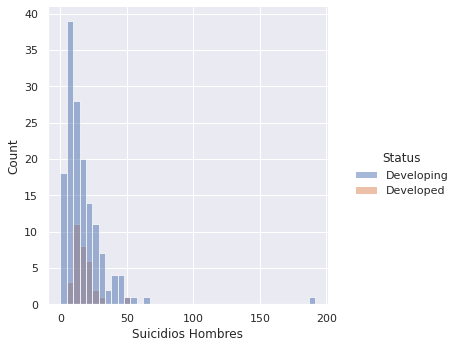

In [10]:
sns.displot(df, x='Suicidios Hombres', bins=40, hue="Status")

### Veo que hay un país en particular muy atípico, veo quién es y lo saco porque creo que puede estropear el análisis.

In [11]:
df[df['Suicidios Ambos'] > 100] 

,Unnamed: 0,Country,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,...,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,Status,Suicidios Ambos,Suicidios Mujeres,Suicidios Hombres
92,94,Lesotho,48.78125,550.0625,4.5,2.086667,82.118913,73.230769,266.6875,25.2375,...,794.52301,1.200528e+06,7.1875,7.06875,0.456813,10.65625,Developing,114.5,45.9,191.5


### Lesotho, se va muy por encima del resto (con un valor normalizado de 10 aproximadamente). Lo saco para que no entorpezca el analisis.

In [12]:
df = df[df['Suicidios Ambos'] < 100] 

### Veamos ambos histogramas comparados

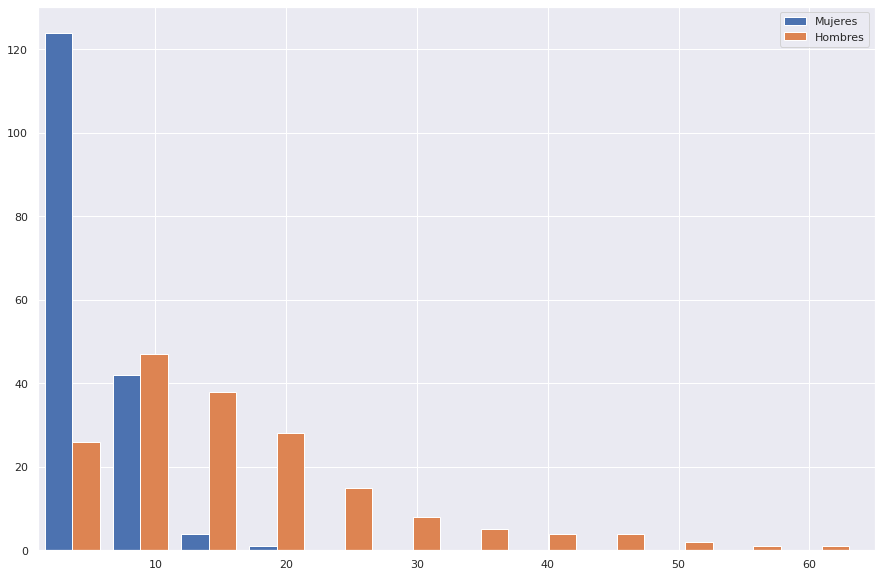

In [13]:
bins = np.linspace(-25, 100, 25)
plt.hist([df['Suicidios Mujeres'], df['Suicidios Hombres']], label=['Mujeres', 'Hombres'], bins = bins)
plt.legend(loc='best')
plt.xlim(1,65)
plt.show()

In [14]:
df['Status_Float'] = df['Status'].apply(lambda x: 0 if x=='Developing' else 1)

/home/andres/anaconda3/envs/tp3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Notamos una mayor correlación de la expectativa de vida con el índice de suicidios de los hombres.

In [15]:
df.corr()['Life expectancy']

Unnamed: 0                        -0.017895
Life expectancy                    1.000000
Adult Mortality                   -0.899833
infant deaths                     -0.205519
Alcohol                            0.460575
percentage expenditure             0.526390
Hepatitis B                        0.431789
Measles                           -0.207260
BMI                                0.725210
under-five deaths                 -0.231813
Polio                              0.678987
Total expenditure                  0.306734
Diphtheria                         0.679694
HIV/AIDS                          -0.573125
GDP                                0.613428
Population                        -0.045117
thinness  1-19 years              -0.524755
thinness 5-9 years                -0.517145
Income composition of resources    0.819759
Schooling                          0.801436
Suicidios Ambos                   -0.298982
Suicidios Mujeres                 -0.341460
Suicidios Hombres               

In [16]:
df.corr()['Suicidios Ambos']

Unnamed: 0                         0.063663
Life expectancy                   -0.298982
Adult Mortality                    0.373800
infant deaths                      0.004714
Alcohol                            0.161604
percentage expenditure            -0.019042
Hepatitis B                       -0.162640
Measles                           -0.005489
BMI                               -0.071603
under-five deaths                  0.009844
Polio                             -0.142786
Total expenditure                  0.124870
Diphtheria                        -0.158532
HIV/AIDS                           0.322337
GDP                               -0.083081
Population                        -0.041342
thinness  1-19 years              -0.017672
thinness 5-9 years                -0.025234
Income composition of resources   -0.131597
Schooling                         -0.062467
Suicidios Ambos                    1.000000
Suicidios Mujeres                  0.870540
Suicidios Hombres               

### Normalizo las tasas y veo qué me dan los análisis

In [17]:
features_a_normalizar = ['Suicidios Ambos','Suicidios Mujeres', 'Suicidios Hombres', 'Life expectancy']
for feature in features_a_normalizar:
    df[f'Norm_{feature}'] = (df[feature]-np.mean(df[feature]))/np.std(df[feature])

/home/andres/anaconda3/envs/tp3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


                            OLS Regression Results                            
Dep. Variable:        Life expectancy   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     17.67
Date:                Sun, 14 Nov 2021   Prob (F-statistic):           4.13e-05
Time:                        18:39:55   Log-Likelihood:                -650.83
No. Observations:                 182   AIC:                             1306.
Df Residuals:                     180   BIC:                             1312.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         69.3373      0.644    107.600      0.0

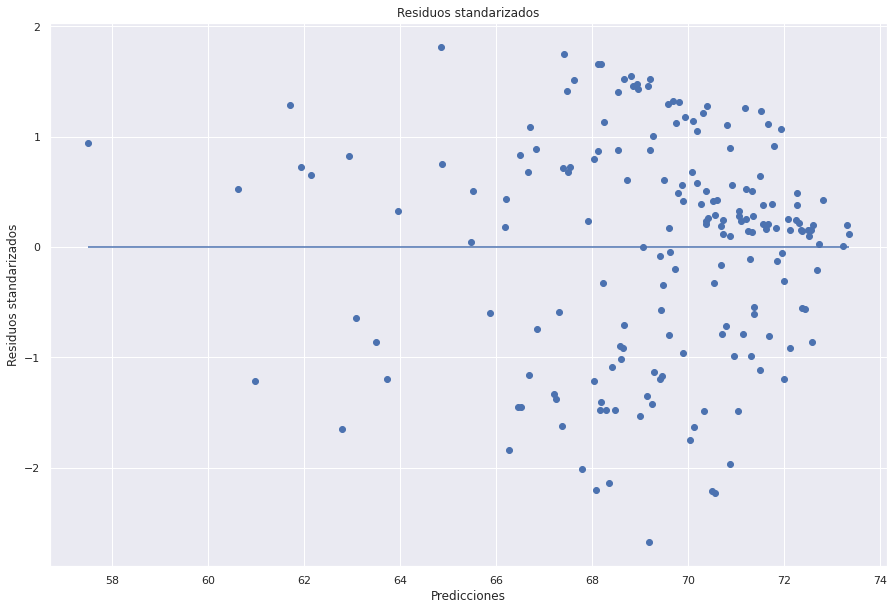

<Figure size 2160x2160 with 0 Axes>

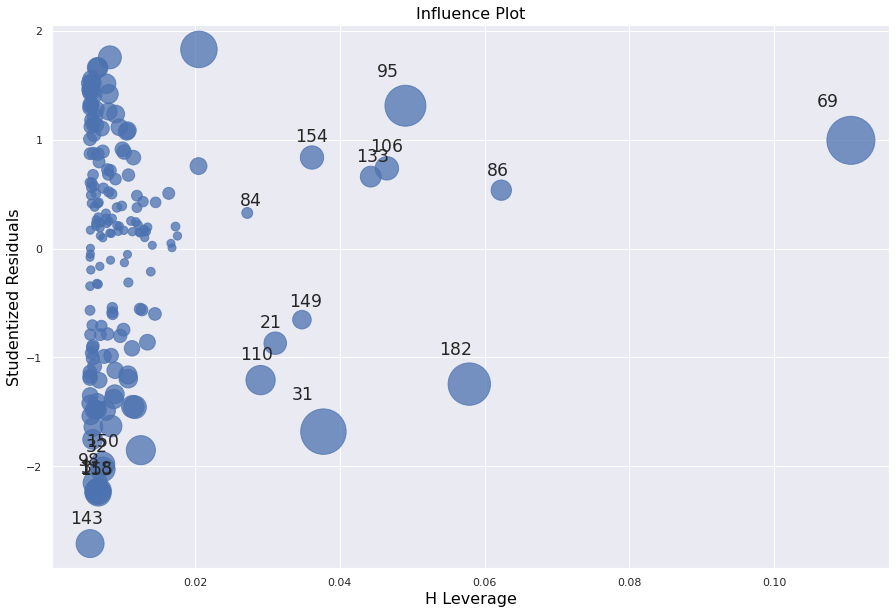

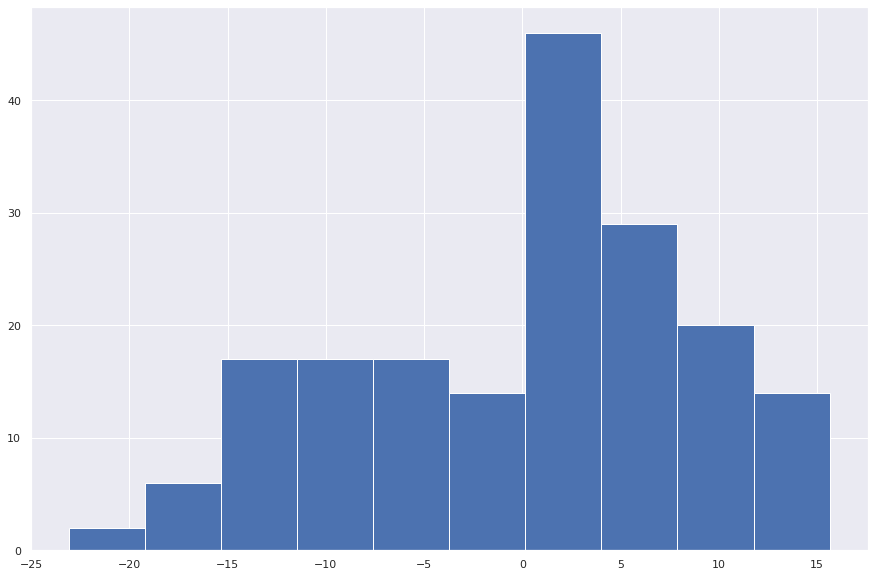

{'r2': 0.08939003714469274,
 'rmse': 8.645475380327136,
 'adjusted': 0.08433109290660767}

In [18]:
run_analysis(['Norm_Suicidios Ambos'], df)

## Modelo - Tasa de suicidios (Hombres)

                            OLS Regression Results                            
Dep. Variable:        Life expectancy   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     17.21
Date:                Sun, 14 Nov 2021   Prob (F-statistic):           5.16e-05
Time:                        18:39:56   Log-Likelihood:                -651.04
No. Observations:                 182   AIC:                             1306.
Df Residuals:                     180   BIC:                             1312.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         69.3373      0.645    107.474      0.0

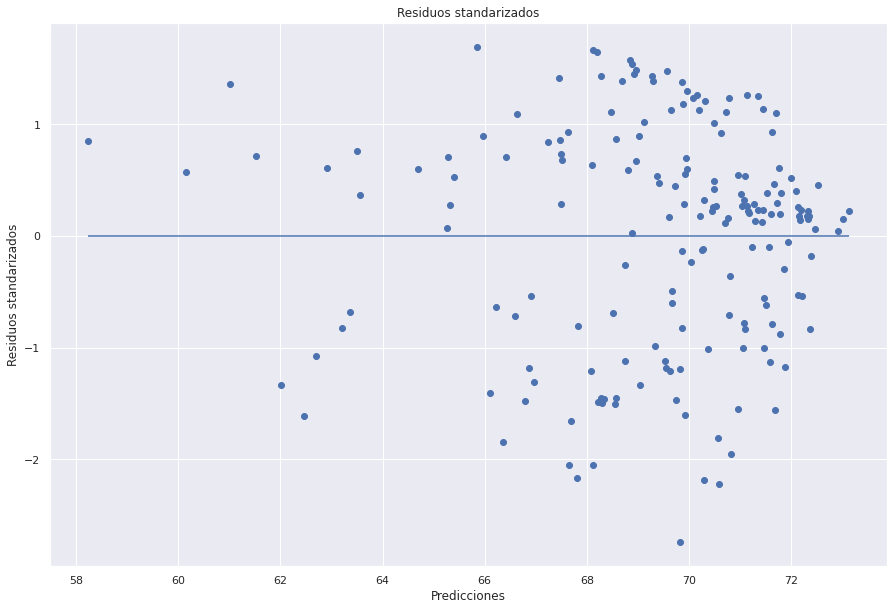

<Figure size 2160x2160 with 0 Axes>

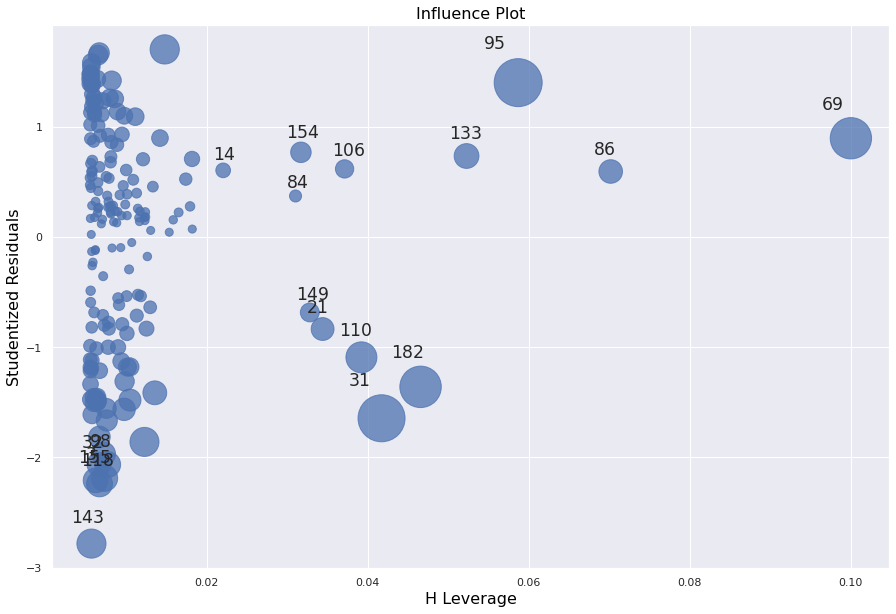

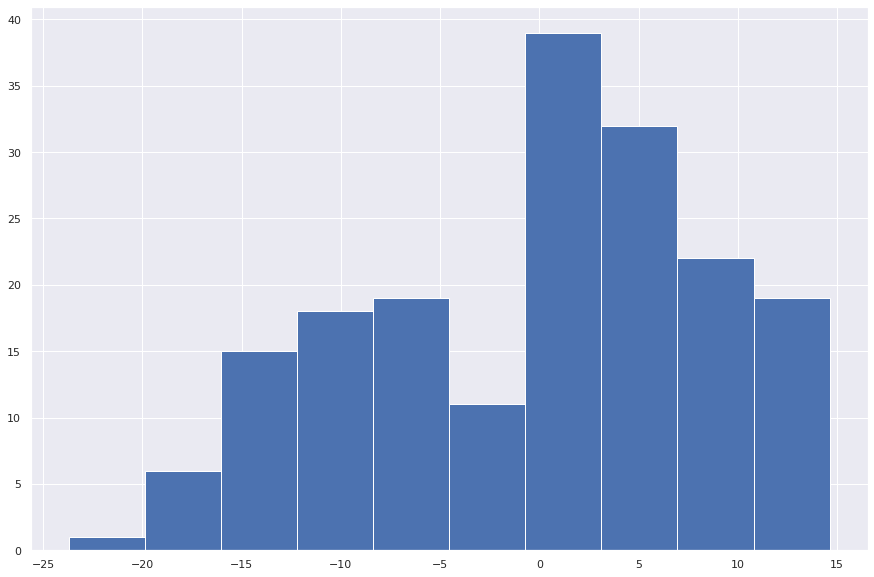

{'r2': 0.08725074777717079,
 'rmse': 8.655624799073447,
 'adjusted': 0.08217991859815499}

In [19]:
run_analysis(['Norm_Suicidios Hombres'], df)

### Llamativamente, poco tienen que ver los suicidios con la expectativa de vida de un país. 

## Modelo - Tasa de suicidios (Mujeres)

                            OLS Regression Results                            
Dep. Variable:        Life expectancy   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     23.76
Date:                Sun, 14 Nov 2021   Prob (F-statistic):           2.39e-06
Time:                        18:39:57   Log-Likelihood:                -648.07
No. Observations:                 182   AIC:                             1300.
Df Residuals:                     180   BIC:                             1307.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         69.3373      0.635    109.245      0.0

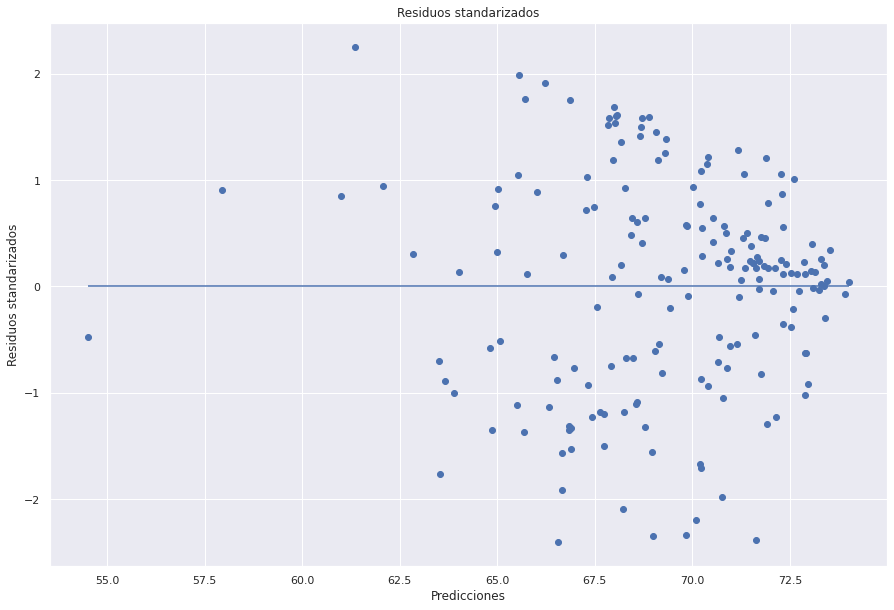

<Figure size 2160x2160 with 0 Axes>

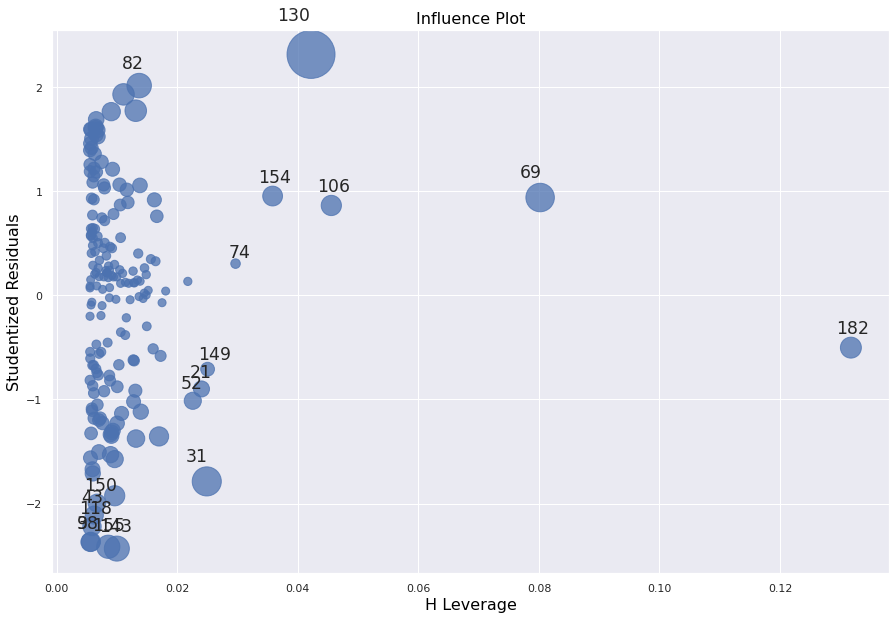

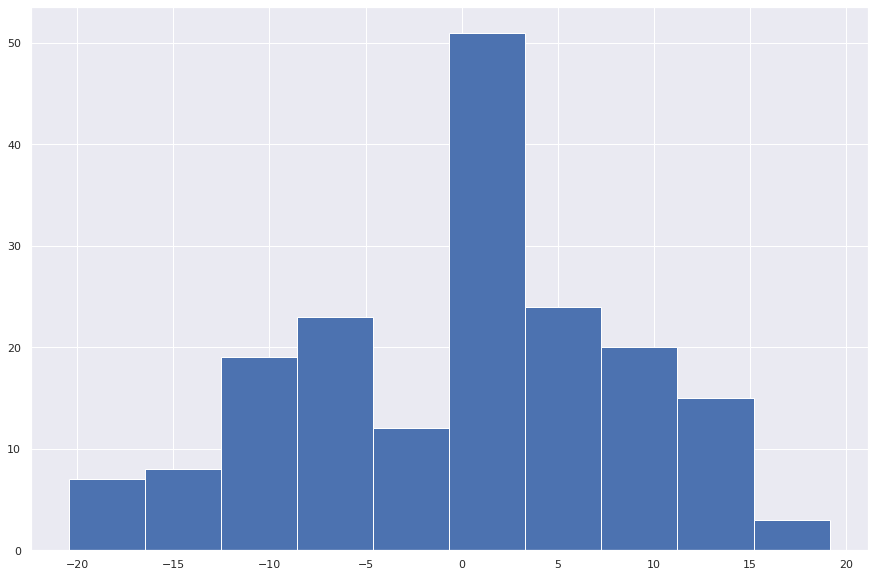

{'r2': 0.116595091452527,
 'rmse': 8.515351578279347,
 'adjusted': 0.111687286405041}

In [20]:
run_analysis(['Norm_Suicidios Mujeres'], df)

### El ajuste de los tres no me dio para nada bien. Lo más rescatable por ahora es el ajuste de la muestra de mujeres.

## Veo como me dan los analisis de los 3 sin outliers

### Me deshago de los residuos mayores a 2

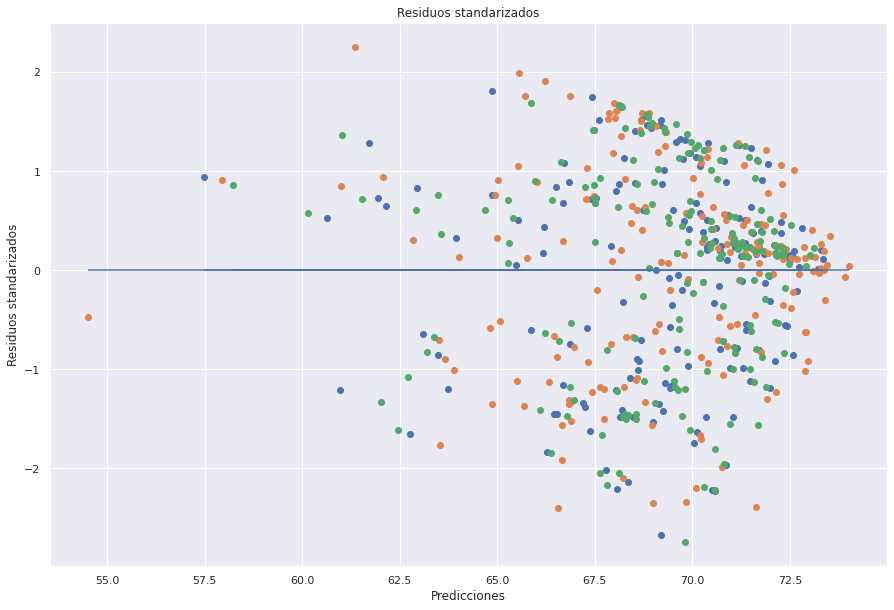

In [21]:
residuos_ambos = residuos(['Norm_Suicidios Ambos'], df)
residuos_m = residuos(['Norm_Suicidios Mujeres'], df)
residuos_h = residuos(['Norm_Suicidios Hombres'], df)
#No pretendia que se grafique

In [22]:
df = df.assign(residuos_ambos = residuos_ambos)
df = df.assign(residuos_m = residuos_m)
df = df.assign(residuos_h = residuos_h)

In [23]:
df_ambos = df[(df["residuos_ambos"]**2)**0.5 <= 2]
df_mujeres = df[(df["residuos_m"]**2)**0.5 <= 2]
df_hombres = df[(df["residuos_h"]**2)**0.5 <= 2]

### Me deshago de los que tengan Distancia de Cook mayor a 0.1

In [24]:
cook_ambos, p_ambos = cooksDist(['Suicidios Ambos'], df_ambos)
cook_m, p_m = cooksDist(['Suicidios Mujeres'], df_mujeres)
cook_h, p_h = cooksDist(['Suicidios Hombres'], df_hombres)

In [25]:
df_ambos = df_ambos.assign(cook_ambos = cook_ambos)
df_mujeres = df_mujeres.assign(cook_m = cook_m)
df_hombres = df_hombres.assign(cook_h = cook_h)

In [26]:
df_ambos = df_ambos[df_ambos["cook_ambos"] < 0.1]
df_mujeres = df_mujeres[df_mujeres["cook_m"] < 0.1]
df_hombres = df_hombres[df_hombres["cook_h"] < 0.1]

### Me deshago de los que tengan Leverage mayor a 0.06

In [27]:
leverage_ambos = getLeverage(['Suicidios Ambos'], df_ambos)
leverage_m = getLeverage(['Suicidios Mujeres'], df_mujeres)
leverage_h = getLeverage(['Suicidios Hombres'], df_hombres)

In [28]:
df_ambos = df_ambos.assign(leverage_ambos = leverage_ambos)
df_mujeres = df_mujeres.assign(leverage_m = leverage_m)
df_hombres = df_hombres.assign(leverage_h = leverage_h)

In [29]:
df_ambos = df_ambos[df_ambos["leverage_ambos"] < 0.06]
df_mujeres = df_mujeres[df_mujeres["leverage_m"] < 0.06]
df_hombres = df_hombres[df_hombres["leverage_h"] < 0.06]

### Rehago los analisis

                            OLS Regression Results                            
Dep. Variable:        Life expectancy   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     20.18
Date:                Sun, 14 Nov 2021   Prob (F-statistic):           1.29e-05
Time:                        18:39:59   Log-Likelihood:                -608.98
No. Observations:                 174   AIC:                             1222.
Df Residuals:                     172   BIC:                             1228.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         74.4270      1.148     64.829      0.0

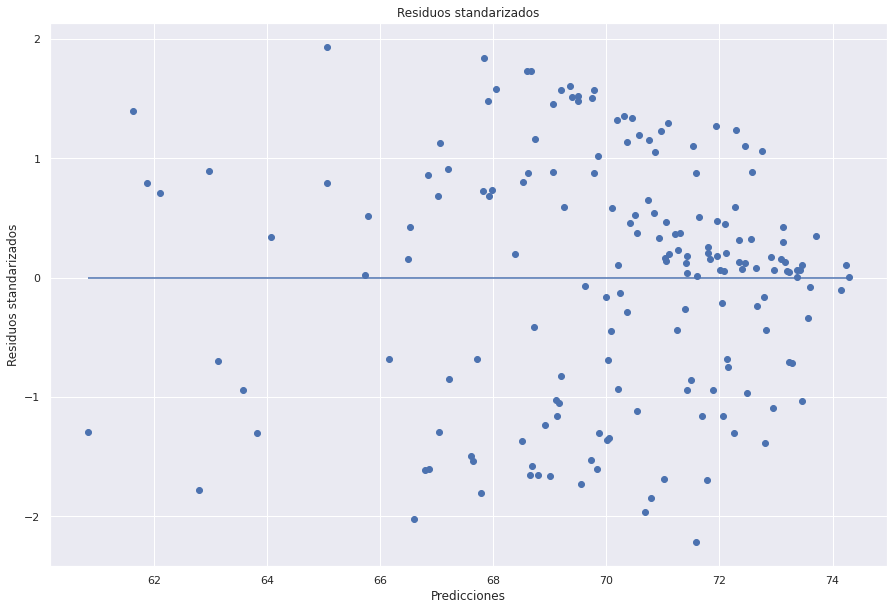

<Figure size 2160x2160 with 0 Axes>

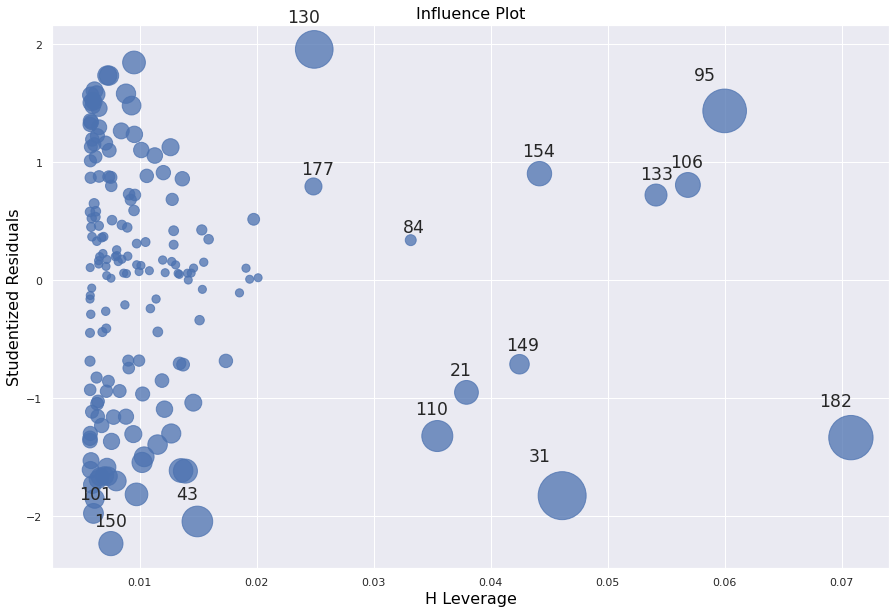

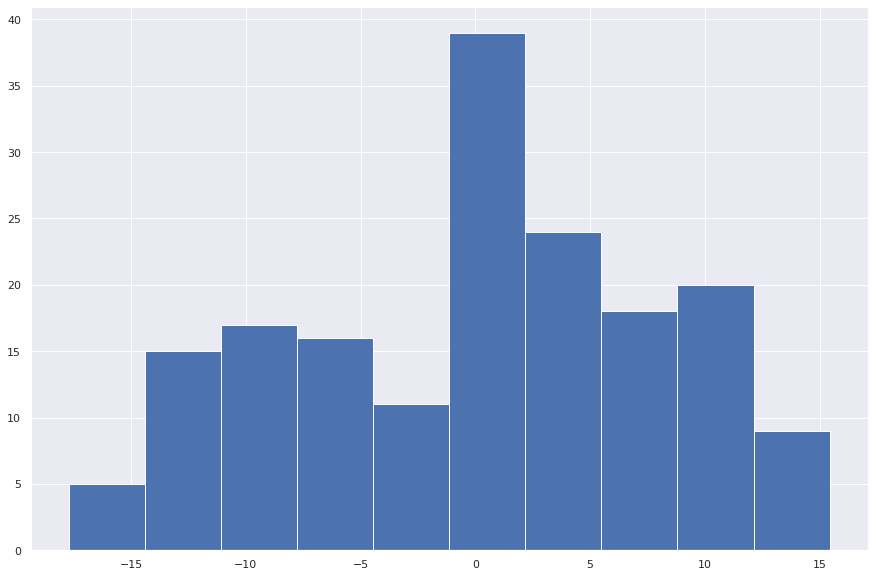

{'r2': 0.10500952668799968,
 'rmse': 8.011858331413283,
 'adjusted': 0.09980609370362759}

In [30]:
run_analysis(['Suicidios Ambos'], df_ambos)

                            OLS Regression Results                            
Dep. Variable:        Life expectancy   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     19.43
Date:                Sun, 14 Nov 2021   Prob (F-statistic):           1.83e-05
Time:                        18:40:01   Log-Likelihood:                -609.31
No. Observations:                 174   AIC:                             1223.
Df Residuals:                     172   BIC:                             1229.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         74.0203      1.087     68.096      0.0

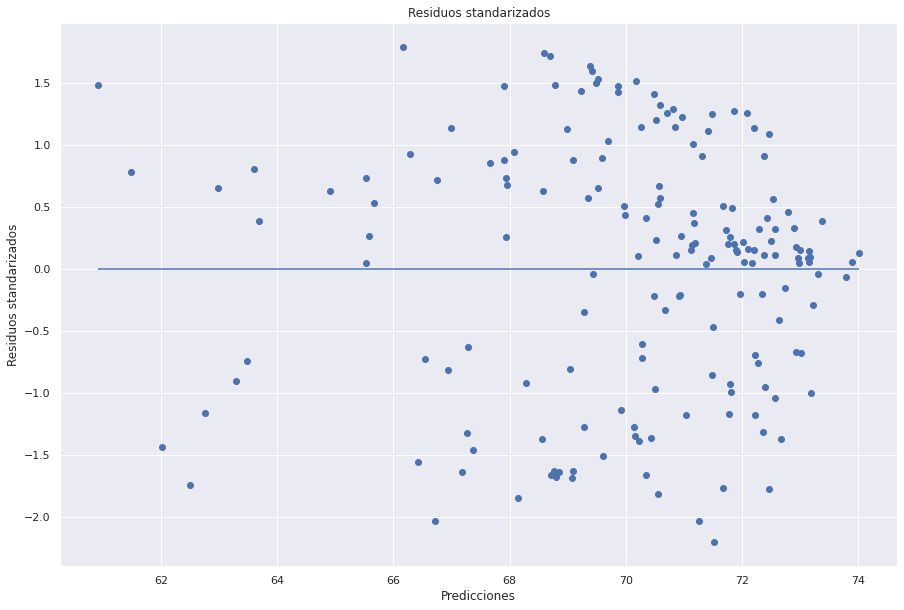

<Figure size 2160x2160 with 0 Axes>

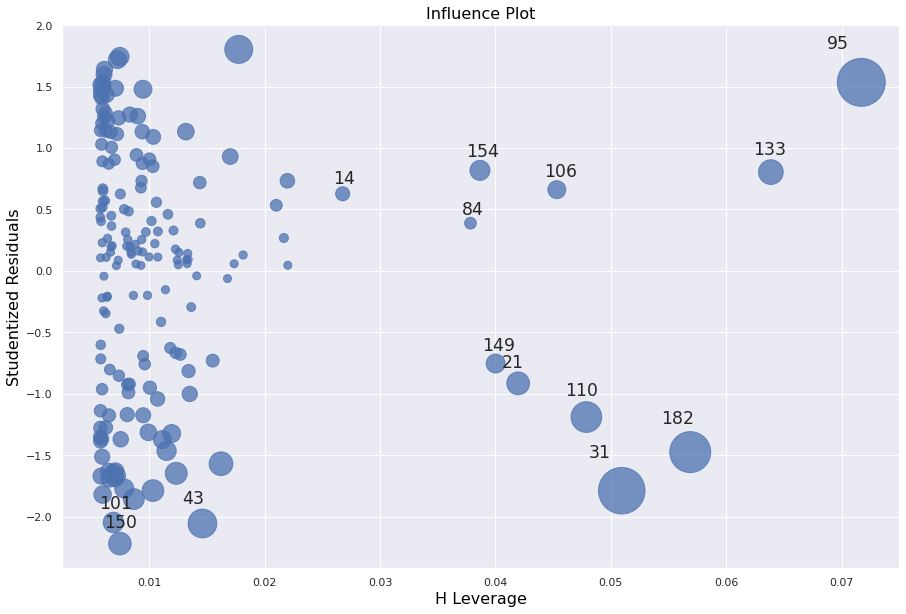

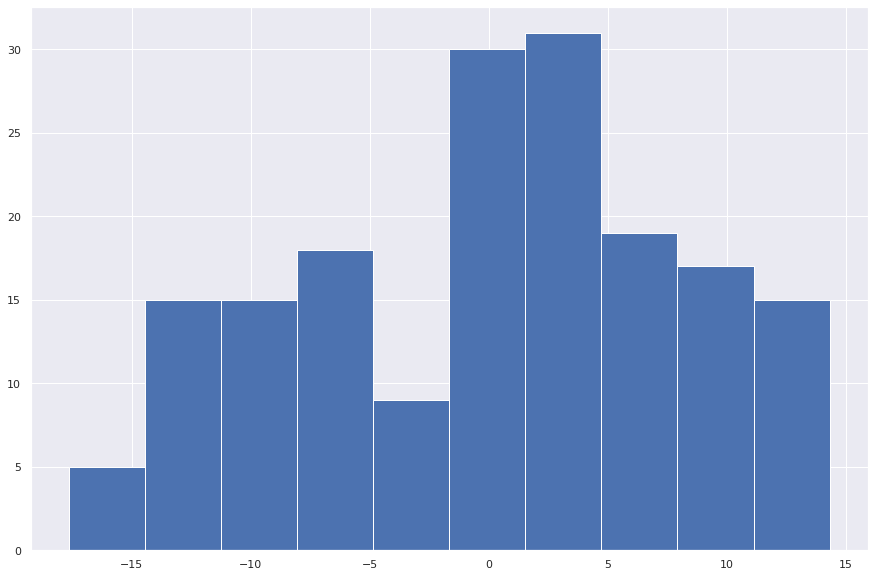

{'r2': 0.10151766267973017,
 'rmse': 8.027472511576125,
 'adjusted': 0.09629392816042637}

In [31]:
run_analysis(['Suicidios Hombres'], df_hombres)

                            OLS Regression Results                            
Dep. Variable:        Life expectancy   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     26.69
Date:                Sun, 14 Nov 2021   Prob (F-statistic):           6.59e-07
Time:                        18:40:02   Log-Likelihood:                -599.72
No. Observations:                 173   AIC:                             1203.
Df Residuals:                     171   BIC:                             1210.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         75.2550      1.163     64.705      0.0

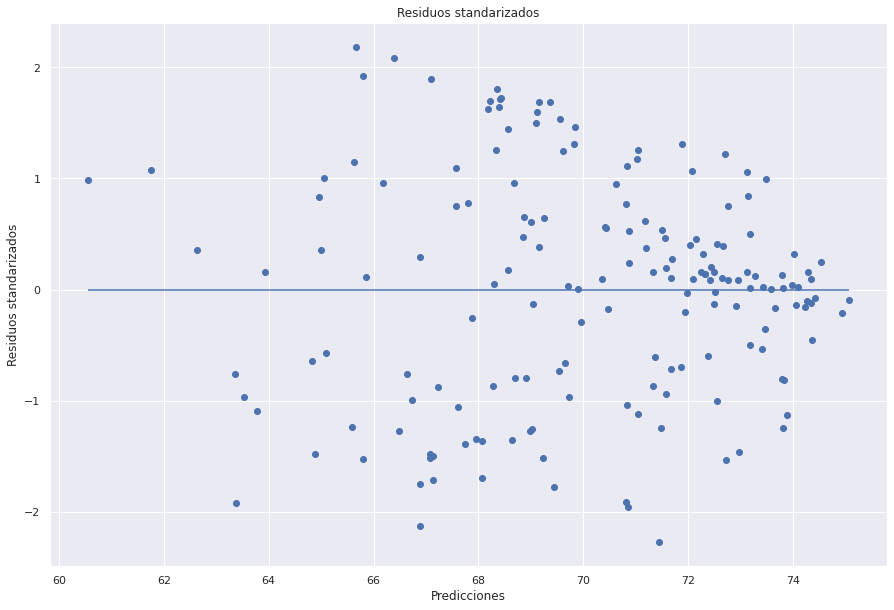

<Figure size 2160x2160 with 0 Axes>

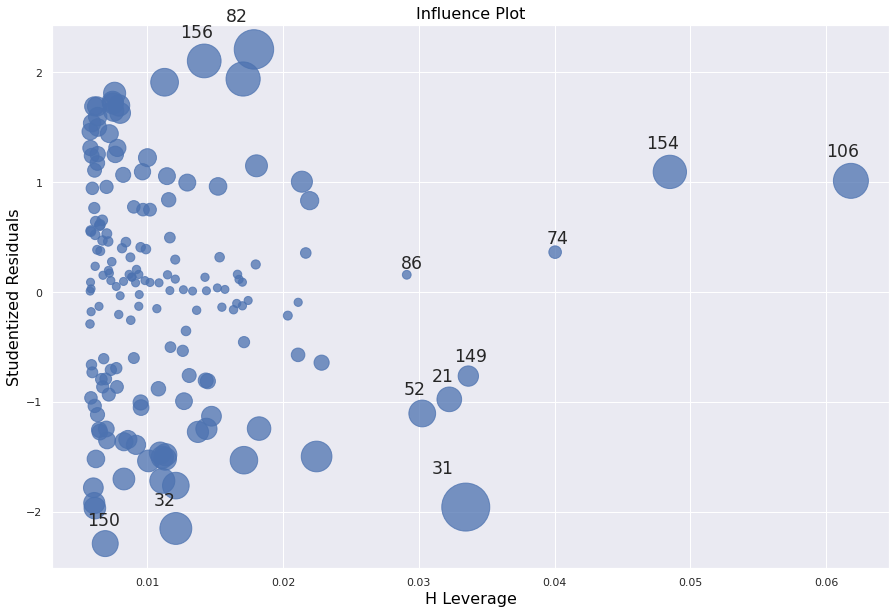

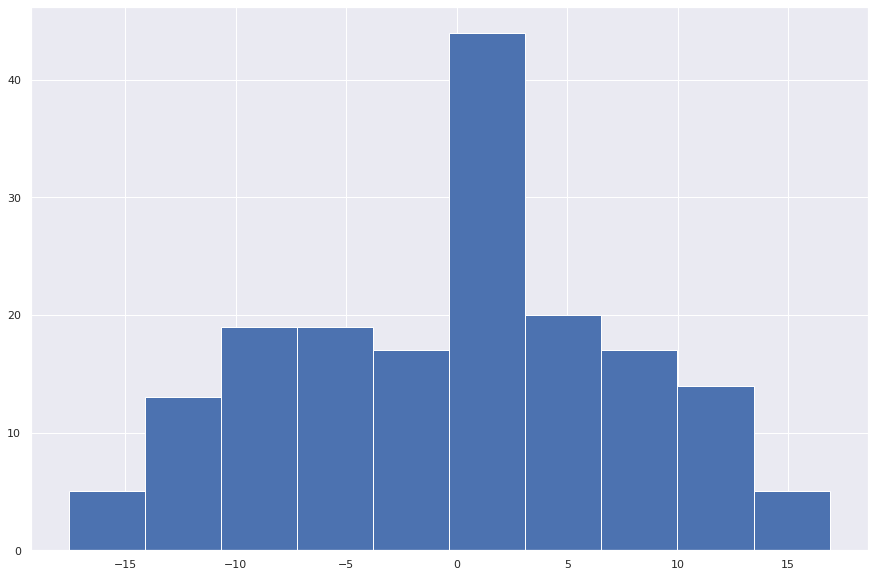

{'r2': 0.1350165844398339,
 'rmse': 7.749664719762427,
 'adjusted': 0.12995820189269836}

In [32]:
run_analysis(['Suicidios Mujeres'], df_mujeres)

### Dan mejor pero ni por asomo obtienen el ajuste esperado. ¿Qué pasa si agregamos como variable el status del país? ¿Eso marcará alguna diferencia?

VIF for Suicidios Ambos 1.193345575676697
VIF for Status_Float 1.1933455756766973
                            OLS Regression Results                            
Dep. Variable:        Life expectancy   R-squared:                       0.397
Model:                            OLS   Adj. R-squared:                  0.390
Method:                 Least Squares   F-statistic:                     56.35
Date:                Sun, 14 Nov 2021   Prob (F-statistic):           1.59e-19
Time:                        18:40:03   Log-Likelihood:                -574.58
No. Observations:                 174   AIC:                             1155.
Df Residuals:                     171   BIC:                             1165.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------

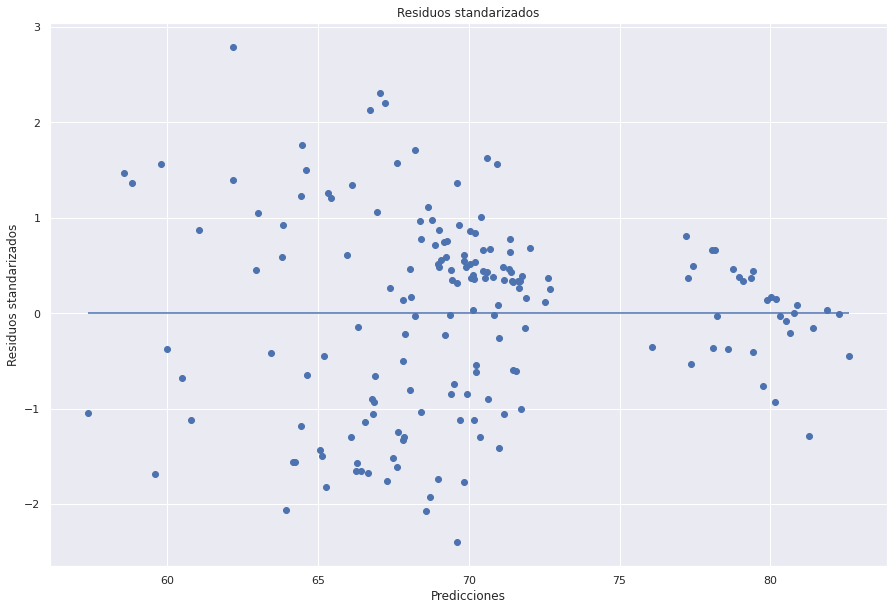

<Figure size 2160x2160 with 0 Axes>

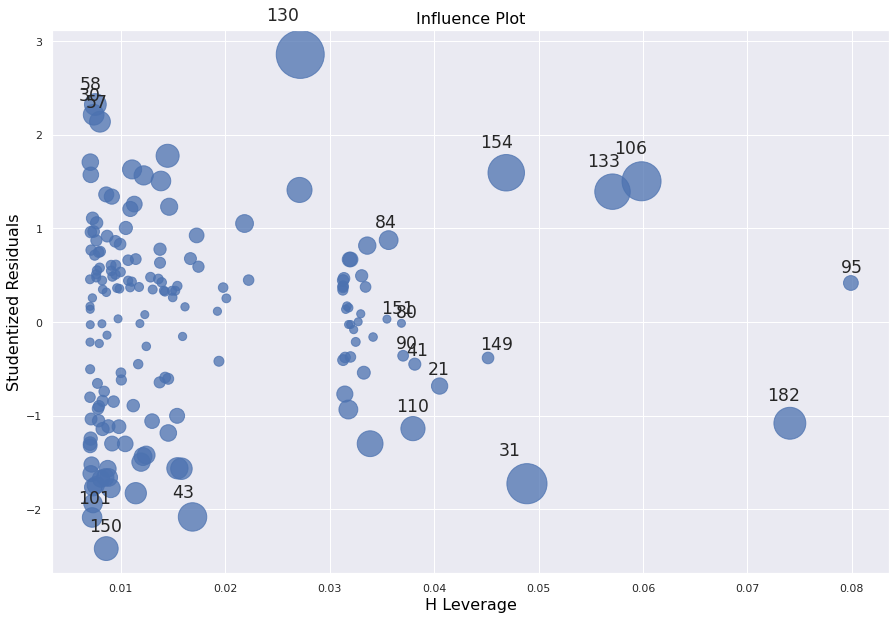

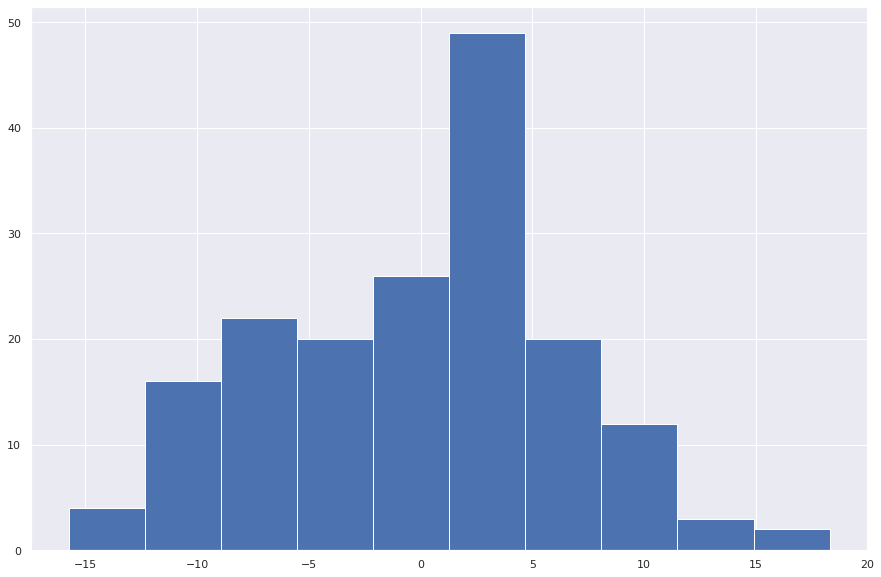

{'r2': 0.3972509542835523,
 'rmse': 6.574947975636926,
 'adjusted': 0.3902012578424242}

In [33]:
run_analysis(['Suicidios Ambos', 'Status_Float'], df_ambos)

VIF for Suicidios Hombres 1.1791630263369823
VIF for Status_Float 1.1791630263369821
                            OLS Regression Results                            
Dep. Variable:        Life expectancy   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.381
Method:                 Least Squares   F-statistic:                     54.31
Date:                Sun, 14 Nov 2021   Prob (F-statistic):           5.49e-19
Time:                        18:40:04   Log-Likelihood:                -575.84
No. Observations:                 174   AIC:                             1158.
Df Residuals:                     171   BIC:                             1167.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------

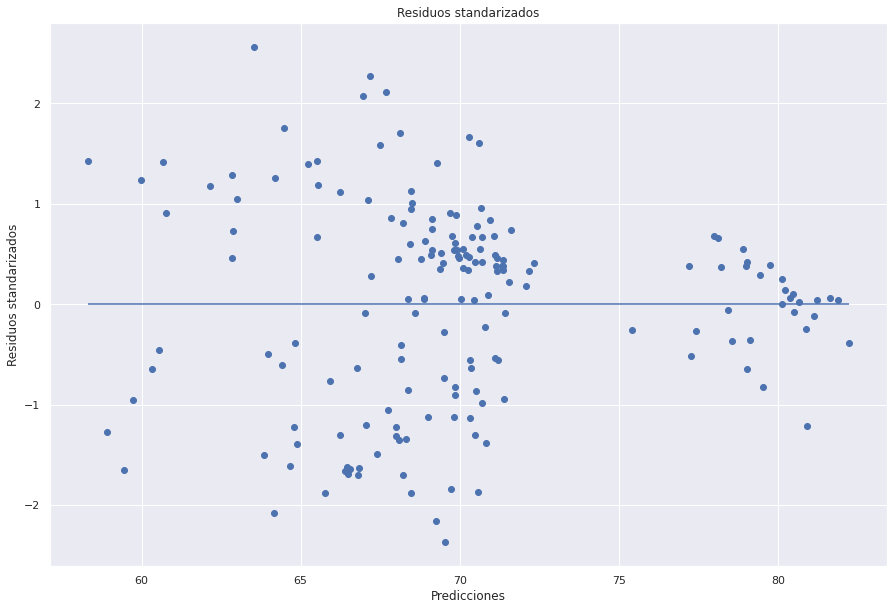

<Figure size 2160x2160 with 0 Axes>

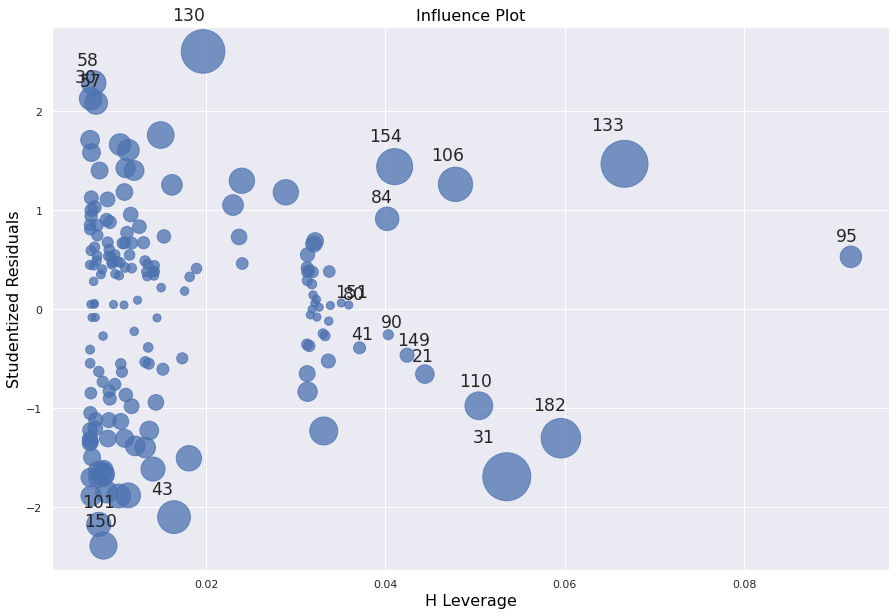

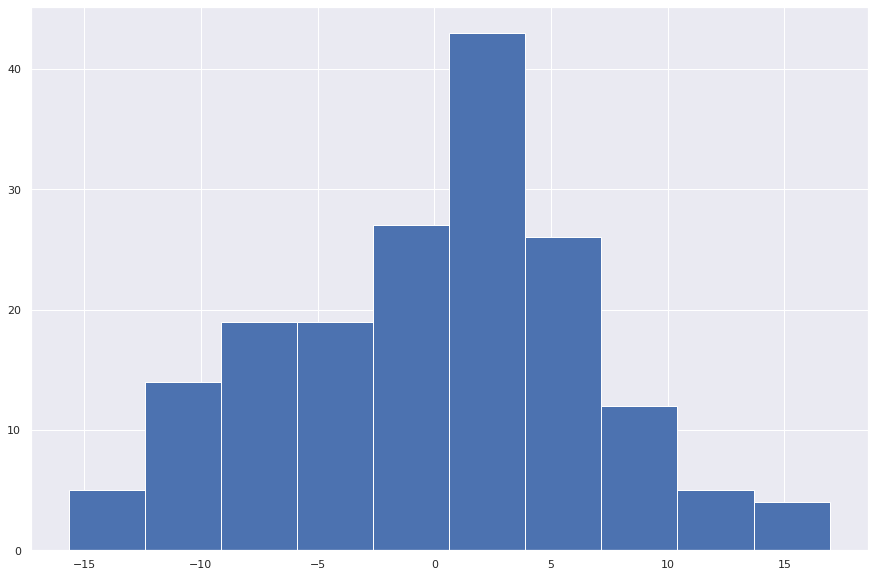

{'r2': 0.3884576407983744,
 'rmse': 6.6227342310251,
 'adjusted': 0.3813050985854899}

In [34]:
run_analysis(['Suicidios Hombres', 'Status_Float'], df_hombres)

VIF for Suicidios Mujeres 1.2087035615440647
VIF for Status_Float 1.2087035615440647
                            OLS Regression Results                            
Dep. Variable:        Life expectancy   R-squared:                       0.449
Model:                            OLS   Adj. R-squared:                  0.442
Method:                 Least Squares   F-statistic:                     69.18
Date:                Sun, 14 Nov 2021   Prob (F-statistic):           1.04e-22
Time:                        18:40:05   Log-Likelihood:                -560.76
No. Observations:                 173   AIC:                             1128.
Df Residuals:                     170   BIC:                             1137.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------

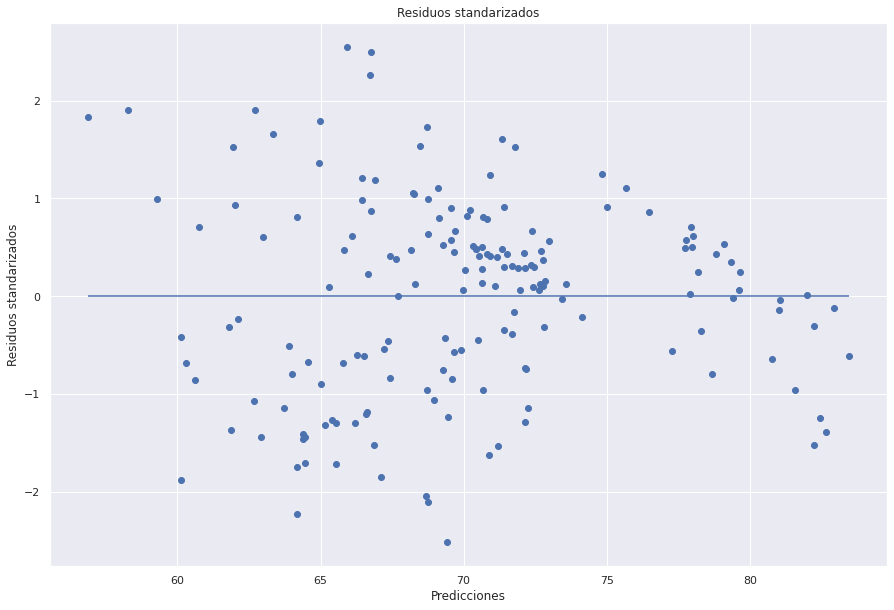

<Figure size 2160x2160 with 0 Axes>

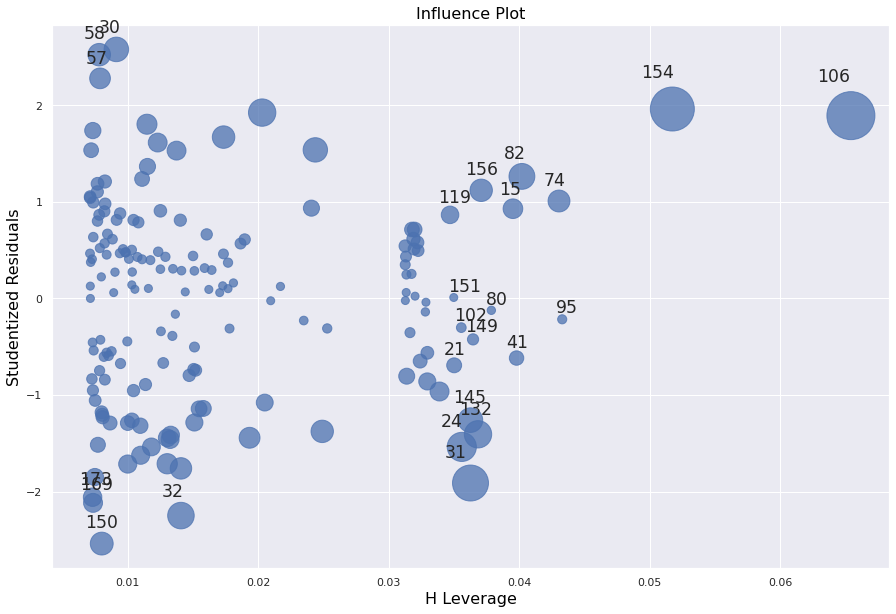

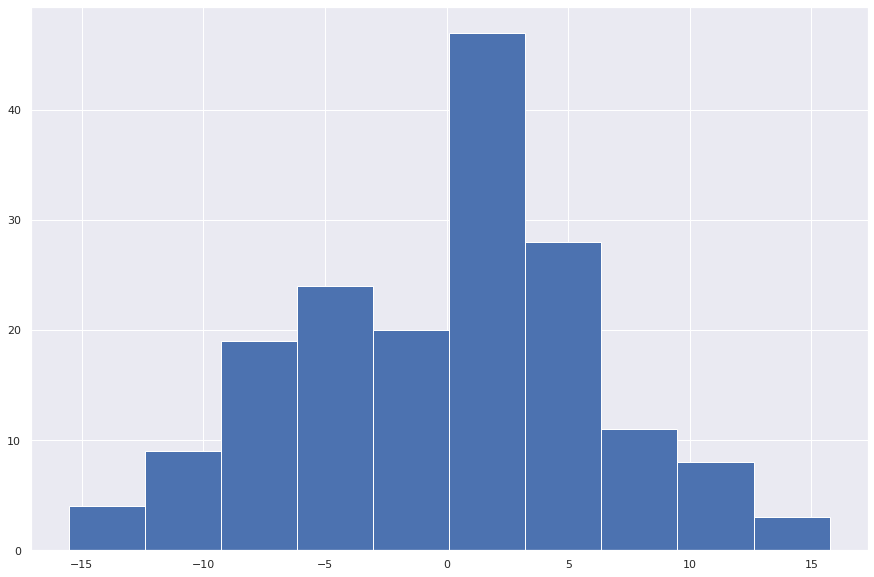

{'r2': 0.44870347768421925,
 'rmse': 6.186879389531056,
 'adjusted': 0.44221763624521004}

In [35]:
run_analysis(['Suicidios Mujeres', 'Status_Float'], df_mujeres)

### Vemos que el ajuste va en aumento, acercandose al 0.5 en el caso de las mujeres. Tener el contexto del país claramente nos ayuda mucho para explicar cómo la tasa de suicidios afecta la expectativa de vida de su población.

### Con esto nos toma por sorpresa el hecho de que la regresión es la mejor cuando se tiene en cuenta sólo a las mujeres y no a ambos sexos.

### Por último hagamos un gráfico de plots con la línea de regresión de los 3 modelos (suicidios de: ambos géneros, hombres y mujeres)

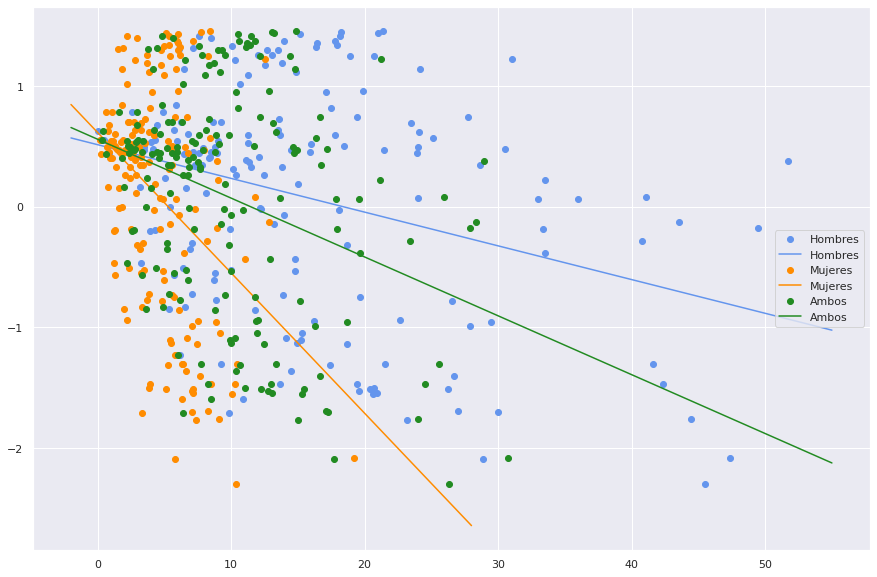

In [36]:
import metnum

lsq = metnum.LeastSquareMethod()

# SCATTER PLOT 1

plt.plot(df_hombres['Suicidios Hombres'], df_hombres['Norm_Life expectancy'], "o", label="Hombres", color='cornflowerblue')

# RECTA 1

unos = np.ones(len(df_hombres))
x = df_hombres["Suicidios Hombres"].values.reshape(-1, 1)
b = df_hombres["Norm_Life expectancy"].values.reshape(-1, 1)
A = np.column_stack((unos, x))

(intercept, slope) = lsq.ajustar(A, b)

puntos_x = np.linspace(-2,55,2)
puntos_y = puntos_x*slope + intercept
plt.plot(puntos_x, puntos_y, label="Hombres", color='cornflowerblue')

# SCATTER PLOT 2

plt.plot(df_ambos['Suicidios Mujeres'], df_ambos['Norm_Life expectancy'], "o", label="Mujeres", color='darkorange')

# RECTA 2

unos = np.ones(len(df_ambos))
x = df_ambos["Suicidios Mujeres"].values.reshape(-1, 1)
b = df_ambos["Norm_Life expectancy"].values.reshape(-1, 1)
A = np.column_stack((unos, x))

(intercept, slope) = lsq.ajustar(A, b)

puntos_x = np.linspace(-2,28,2)
puntos_y = puntos_x*slope + intercept
plt.plot(puntos_x, puntos_y, label="Mujeres", color='darkorange')

# SCATTER PLOT 3

plt.plot(df_ambos['Suicidios Ambos'], df_ambos['Norm_Life expectancy'], "o", label="Ambos", color='forestgreen')

# RECTA 3

unos = np.ones(len(df_ambos))
x = df_ambos["Suicidios Ambos"].values.reshape(-1, 1)
b = df_ambos["Norm_Life expectancy"].values.reshape(-1, 1)
A = np.column_stack((unos, x))

(intercept, slope) = lsq.ajustar(A, b)

puntos_x = np.linspace(-2,55,2)
puntos_y = puntos_x*slope + intercept
plt.plot(puntos_x, puntos_y, label="Ambos", color='forestgreen')

plt.legend(loc='center right')